<a href="https://colab.research.google.com/github/RoyElkabetz/NMR-gyroscope/blob/main/PID_and_LIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections.abc import Iterator, Generator
'https://jckantor.github.io/CBE30338/04.01-Implementing_PID_Control_with_Python_Yield_Statement.html'
import numpy as np
import matplotlib.pyplot as plt
import json
import time

np.random.seed(216)

The PID equation is given by

\begin{align}
    MV_k &= \overline{MV} + K_P \epsilon_k + K_I \sum_{k'=0}^{k}\epsilon_{k'}\left(t_k - t_{k-1}\right) + K_D \frac{\epsilon_k - \epsilon_{k-1}}{t_k - t_{k-1}}
\end{align}

# PID Comtroller using a class with generator

In [ ]:
class PIDcontroller:
    def __init__(self, Kp, Ki, Kd, MV_bar=0, beta=1 ,gamma=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.MV_bar = MV_bar
        self.beta = beta
        self.gamma = gamma

    def lock(self):
        # initialize stored data
        eD_prev = 0
        t_prev = -1000
        P = 0
        I = 0
        D = 0
        
        # initial control
        MV = self.MV_bar
        
        while True:
            # # yield MV, wait for new t, SP, PV, TR
            # t, PV, SP, TR = yield MV
            
            # # adjust I term so output matches tracking input
            # I = TR - MV_bar - P - D

            t, PV, SP = yield MV

            
            # PID calculations
            P = self.Kp * (self.beta *  SP - PV)
            I = I + self.Ki * (SP - PV) * (t - t_prev)
            eD = self.gamma * SP - PV
            D = self.Kd * (eD - eD_prev) / (t - t_prev)
            MV = self.MV_bar + P + I + D
            
            # update stored data for next iteration
            eD_prev = eD
            t_prev = t

In [ ]:
tf = 100
time = np.linspace(0, tf, tf * 10)
setpoint = [0 if t < tf / 2 else 10 for t in time]
temperature = [5] * len(time) + np.random.rand(len(time))

In [ ]:
pid_controller = PIDcontroller(1, 0.01, 0)
pid = pid_controller.lock()
pid.send(None)
for i, t in enumerate(time[:-1]):
    SP = setpoint[i]
    PV = temperature[i]
    MV = pid.send([t, PV, SP])
    temperature[i + 1] = 0.9 * MV

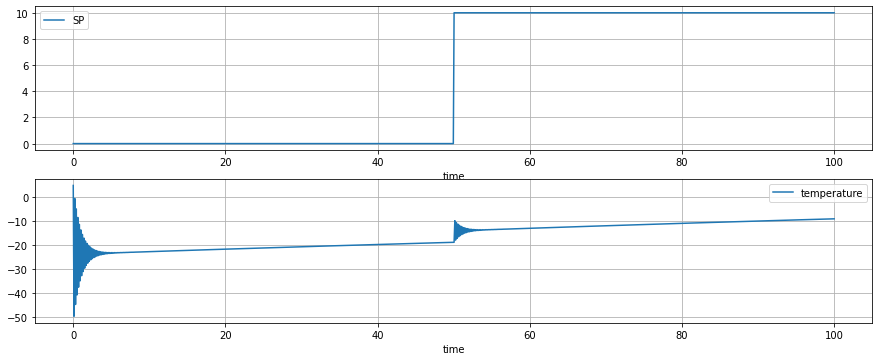

In [ ]:
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot(311)
ax1.plot(time, setpoint, label="SP")
ax1.set_xlabel('time')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(312)
ax2.plot(time, temperature, label="temperature")
ax2.set_xlabel('time')
ax2.legend()
ax2.grid()

# PID Comtroller using a class without a generator

In [48]:
class PIDcontroller:
    def __init__(self, Kp, Ki, Kd, fs_system, fs_pid, MV_bar=0, MV_lim_n=-100, MV_lim_p=100, beta=1 ,gamma=0, save_error=False):
        """"""
        assert fs_system >= fs_pid
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.fs_system = fs_system        # the sampling frequency of the physics
        self.fs_pid = fs_pid              # the sampling frequency of the PID
        self.MV_bar = MV_bar              # initial MV
        self.MV_lim_p = MV_lim_p          # MV upper limit
        self.MV_lim_n = MV_lim_n          # MV lower limit
        self.beta = beta                  
        self.gamma = gamma
        self.eD_prev = 0
        self.t_prev = -1000
        self.I = 0
        self.e_saved = [0]
        self.save_error = save_error 

    def lock(self, t, PV, SP, TR=None):
        # initialize stored data
        P = 0
        I = 0
        D = 0
        
        # adjust I term so output matches tracking input
        if TR is not None:
            self.I = TR - self.MV_bar
        
        # initial control
        MV = self.MV_bar
        
        # PID calculations
        P = self.Kp * (SP - PV)
        I = self.I + self.Ki * (SP - PV) * (t -  self.t_prev)
        eD = SP - PV
        D = self.Kd * (eD - self.eD_prev) / (t -  self.t_prev)
        MV = self.MV_bar + P + I + D
        # set value to saturated MV if out of range 
        if MV < self.MV_lim_n:
            MV = self.MV_lim_n
        if MV > self.MV_lim_p:
            MV = self.MV_lim_p
        
        # update stored data for next iteration
        self.eD_prev = eD
        self.t_prev = t
        self.MV_bar = MV
        self.I = I
        if self.save_error:
            self.e_saved.append(P + I + D)
        
        return MV

In [49]:
fs_system = 1000
fs_pid = 100
tf = 10
time = np.linspace(0, tf, tf * fs_system)
setpoint = np.array([32 if t < tf / 2 else 11 for t in time])
uselock = np.array([False] * int(len(time) / 3) + [True] * int(len(time) + 1 - len(time) / 3))
temperature1 = [25] * (len(time) + 1) + np.random.rand((len(time) + 1))
temperature2 = [25] * (len(time) + 1) + np.random.rand((len(time) + 1))

In [50]:
pid_controller1 = PIDcontroller(0.7, 0.0001, 0, fs_system, fs_pid, MV_lim_n=-100, MV_lim_p=100, save_error=True)
pid_controller2 = PIDcontroller(1, 0, 0, fs_system, fs_pid, MV_lim_n=-10, MV_lim_p=10)
for i, t in enumerate(time):
    PV1 = temperature1[i]
    PV2 = temperature2[i]
    SP = setpoint[i]
    if uselock[i]:
        if t != 0 and t % (pid_controller1.fs_pid ** -1) <= (fs_system ** -1):
            temperature1[i + 1] = pid_controller1.lock(t, PV1, SP, PV1)
        else:
            temperature1[i + 1] = temperature1[i] * (1 + 0.01 * np.random.rand())
        if t != 0 and t % (pid_controller2.fs_pid ** -1) <= (fs_system ** -1):
            temperature2[i + 1] = pid_controller2.lock(t, PV2, SP)
        else:
            temperature2[i + 1] = temperature2[i] * (1 + 0.01 * np.random.normal())

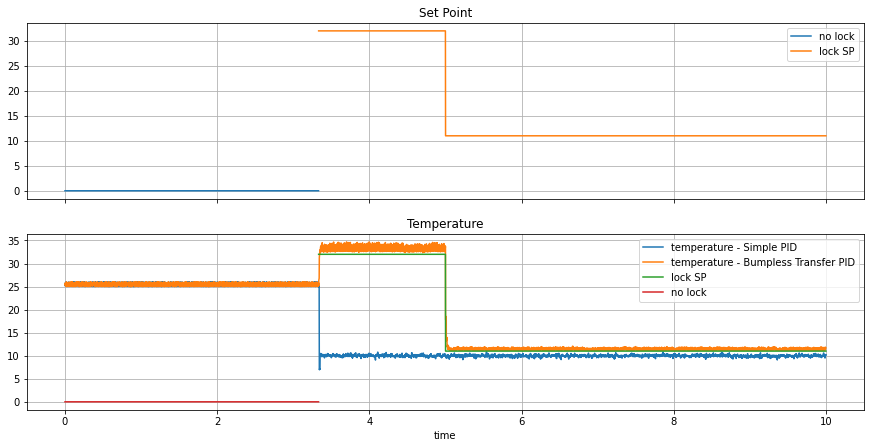

In [51]:
nolock = [True if b==False else False for b in uselock]


fig = plt.figure(figsize=(15, 11))
ax1 = plt.subplot(311)
ax1.plot(time[nolock], 0 * setpoint[nolock], label="no lock")
ax1.plot(time[uselock], setpoint[uselock], label="lock SP")
#ax1.fill_between(range(len(setpoint[uselock])),setpoint[uselock])
ax1.set_title('Set Point')
ax1.set_xticklabels([])
ax1.legend()
ax1.grid()

ax2 = plt.subplot(312)
ax2.plot(time, temperature2[:-1], label="temperature - Simple PID")
ax2.plot(time, temperature1[:-1], label="temperature - Bumpless Transfer PID")
ax2.plot(time[uselock], setpoint[uselock], label="lock SP")
ax2.plot(time[nolock], 0 * setpoint[nolock], label="no lock")
ax2.set_xlabel('time')
ax2.set_title('Temperature')
ax2.legend()
ax2.grid()


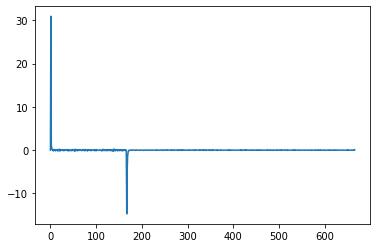

In [52]:
plt.plot(pid_controller1.e_saved)